## Experiment 1: Ion Barrier Mesh Retardation Potential

This experiment computes the voltage that must be applied to a given ion barrier mesh configuration in order to prevent any particles from being transmitted.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import libem
import numpy as np
from libvis import Visualizations, VideoMaker
import matplotlib.pyplot as plt

from components import *

from scipy.optimize import root_scalar

**Global Configuration**

In [4]:
def generate_barrier_space(V_out=1, V_in=-1, grate_dist=0.5, grate_sp=0.2, th=0.05, scale=30):
    sim = libem.EMSimulationSpace3D(space_size=(2, 2, 2), top_left=(-1, -1, -1), scale=scale)
    sim.compute(make_enforcer(
        enf(EMObjects.planar_mesh_3d, (grate_dist, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
        enf(EMObjects.planar_mesh_3d, (0, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_in),
        enf(EMObjects.planar_mesh_3d, (-grate_dist, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
    ))
    sim.get_efield()
    return sim

TIME = 2
THICKNESS = 0.05
SCALE = 30

particle_opts = {
    "mass": (1, 0),
    "charge": (1, 0),
    "initial_loc": ((0.9, 0, 0), (0, 0, 0)),
    "initial_v": ((-1, 0, 0), (0.2, 0.05, 0.05)),
    "bounce_coef": None
}

**Dependence on Grate Size**

<IPython.core.display.Javascript object>


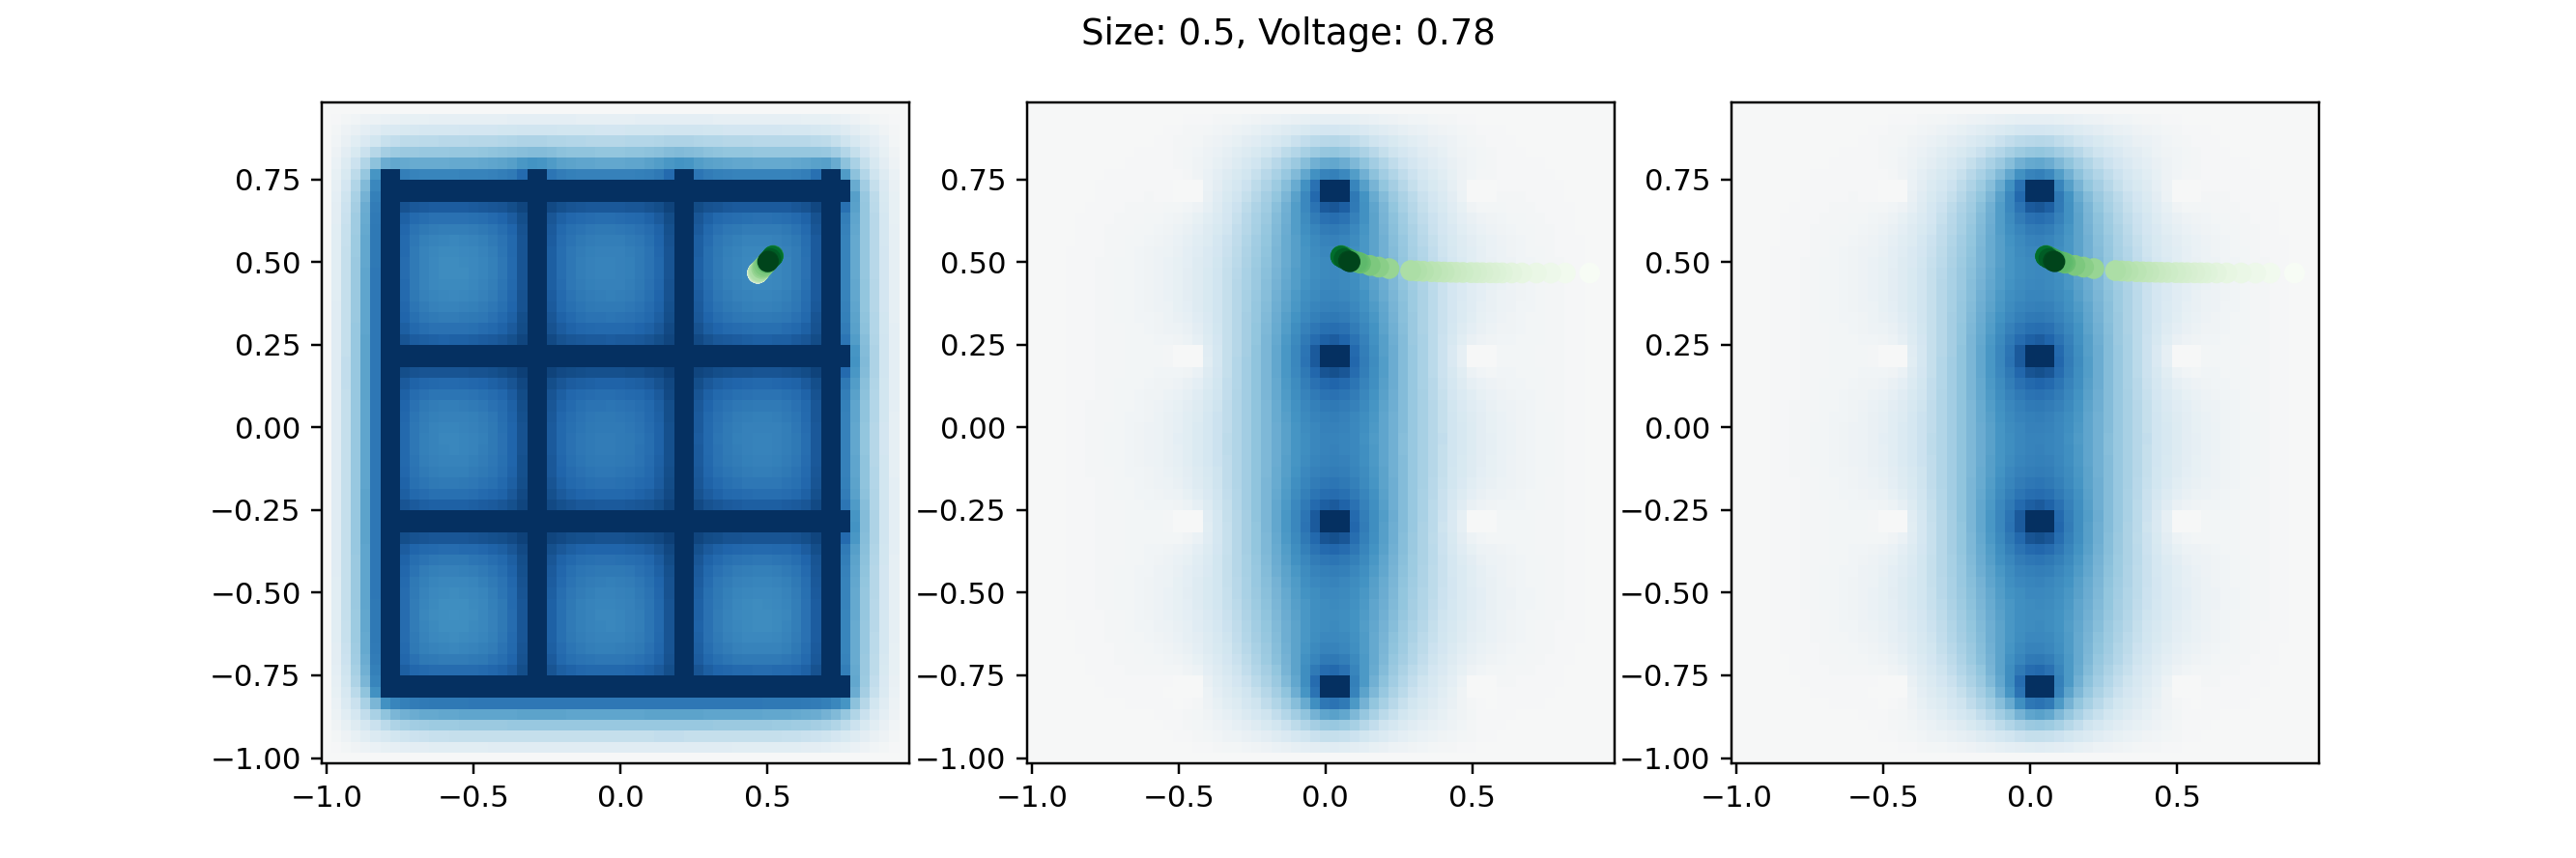

Computing Dependence
Computation Finished.


In [8]:
GRATE_DIST = 0.5

size_range = np.arange(0, 0.55, 0.05)
blocking_v = np.zeros(size_range.shape)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.show()
video = VideoMaker(fig, axes)

def final_x_pos(sp_id, voltage):
    sim = generate_barrier_space(0, voltage, GRATE_DIST, size_range[sp_id], THICKNESS, SCALE)
    
    ctr = sim.global_unit_to_point((0, 0, 0))
    sq = round(size_range[sp_id] * sim.scale) if size_range[sp_id] > 0 else 1
    vs = sim.V[ctr[0],ctr[1]-sq:ctr[1]+sq,ctr[2]-sq:ctr[2]+sq]
    minv_pos = np.array(np.unravel_index(vs.argmin(), vs.shape))
    minv_pos += np.array([ctr[1]-sq, ctr[2]-sq])
    
    minv_loc = sim.point_to_global_unit(minv_pos)
    
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       (particle_opts["initial_loc"][0][0], minv_loc[0], minv_loc[1]),
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, TIME))
    
    video.new_frame()
    fig.suptitle("Size: " + str(round(size_range[sp_id], 2)) + ", Voltage: " + str(round(voltage, 2)))
    for i, ax in enumerate(axes):
        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=(0 if i==0 else minv_loc[i-1]))
        Visualizations.colormesh_2d(sim2d, color_norm=voltage, graph_ax=ax)
        Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)
    video.draw_frame()
    
    return particle.position[0][-1]

print("Computing Dependence")
qKE = particle_opts["charge"][0] * 0.5 * particle_opts["mass"][0] * (particle_opts["initial_v"][0][0]**2)
for i, size in enumerate(size_range):
    f = lambda v: final_x_pos(i, v)
    
    sol = root_scalar(f, method="bisect", bracket=[0.75*qKE, 2*qKE], x0=qKE, xtol=0.01)
    blocking_v[i] = sol.root
    print("\r", round(size, 2), ":", str(round(sol.root, 2)).rjust(4), end="")
print("\rComputation Finished.")

video.make_movie("grate_size.mp4")

<IPython.core.display.Javascript object>


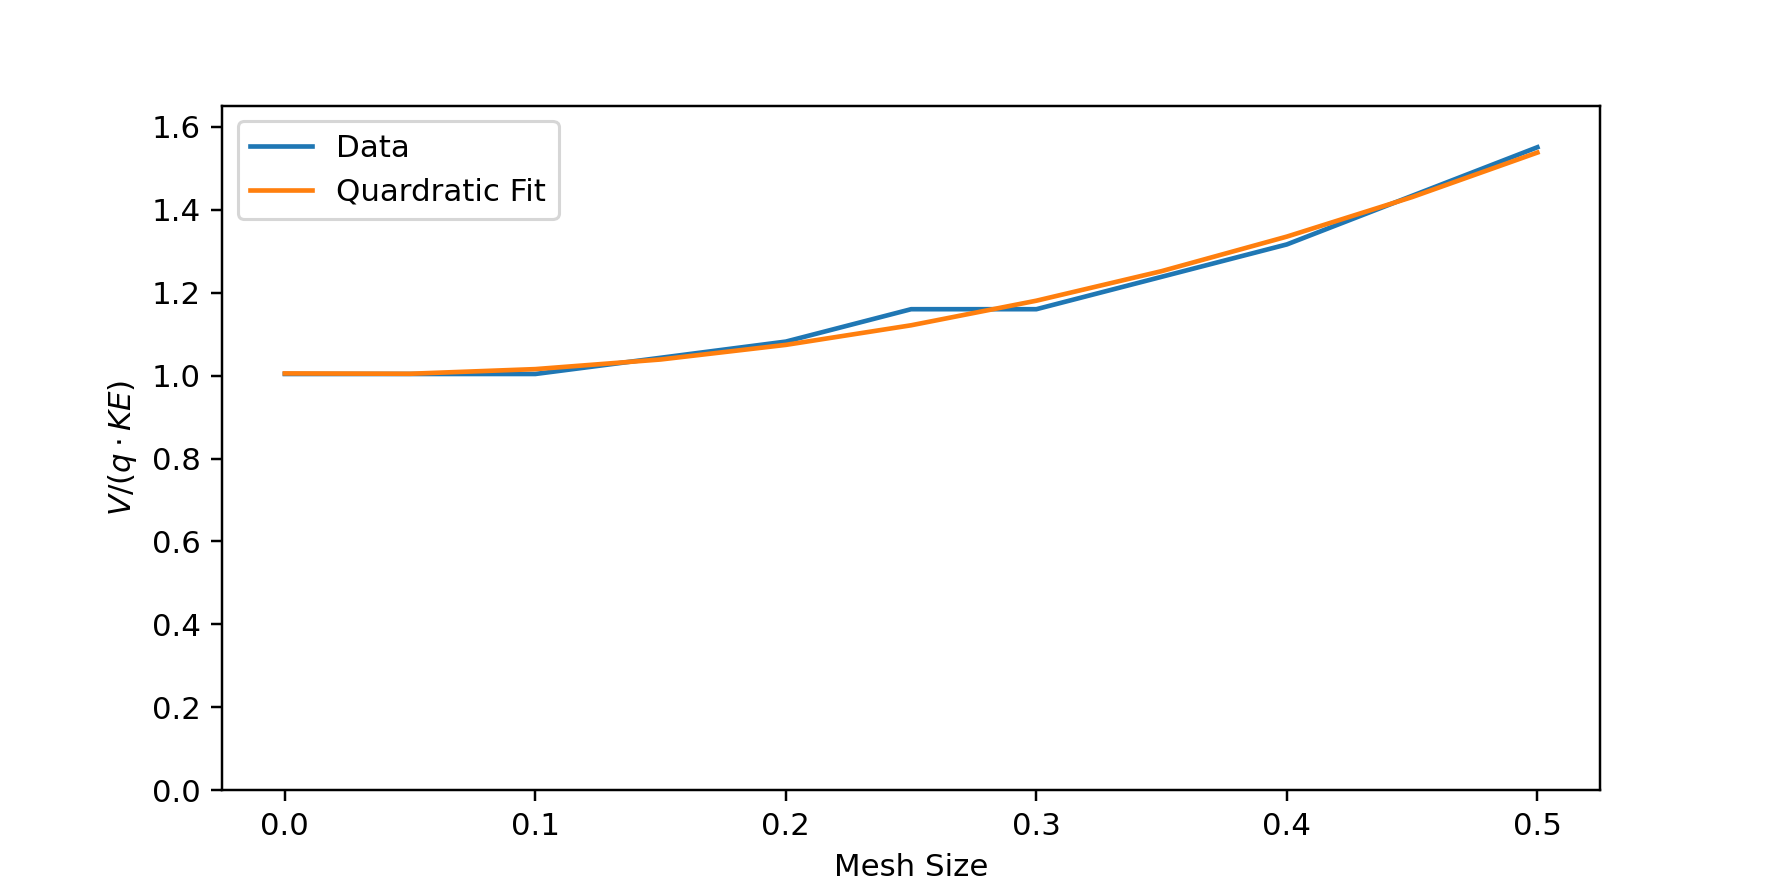

V/(qKE) = 2.40 * size^2 + -0.14 * size + 1.005272


In [15]:
plt.figure(figsize=(8, 4))

rel_V = blocking_v / qKE

fit = np.polyfit(size_range, rel_V, 2)
fit_f = lambda x: sum([fit[-(p+1)] * x**(p) for p in range(len(fit))])
plt.plot(size_range, rel_V, label="Data")
plt.plot(size_range, fit_f(size_range), label="Quardratic Fit")
plt.legend()
plt.xlabel("Mesh Size")
plt.ylabel("$V / (q \cdot KE)$")
plt.ylim((0, max(rel_V)+0.1))
plt.show()

print("V/(qKE) = {:.2f} * size^2 + {:.2f} * size + {:2f}".format(*fit))

**Dependence on Grate Separation**

<IPython.core.display.Javascript object>


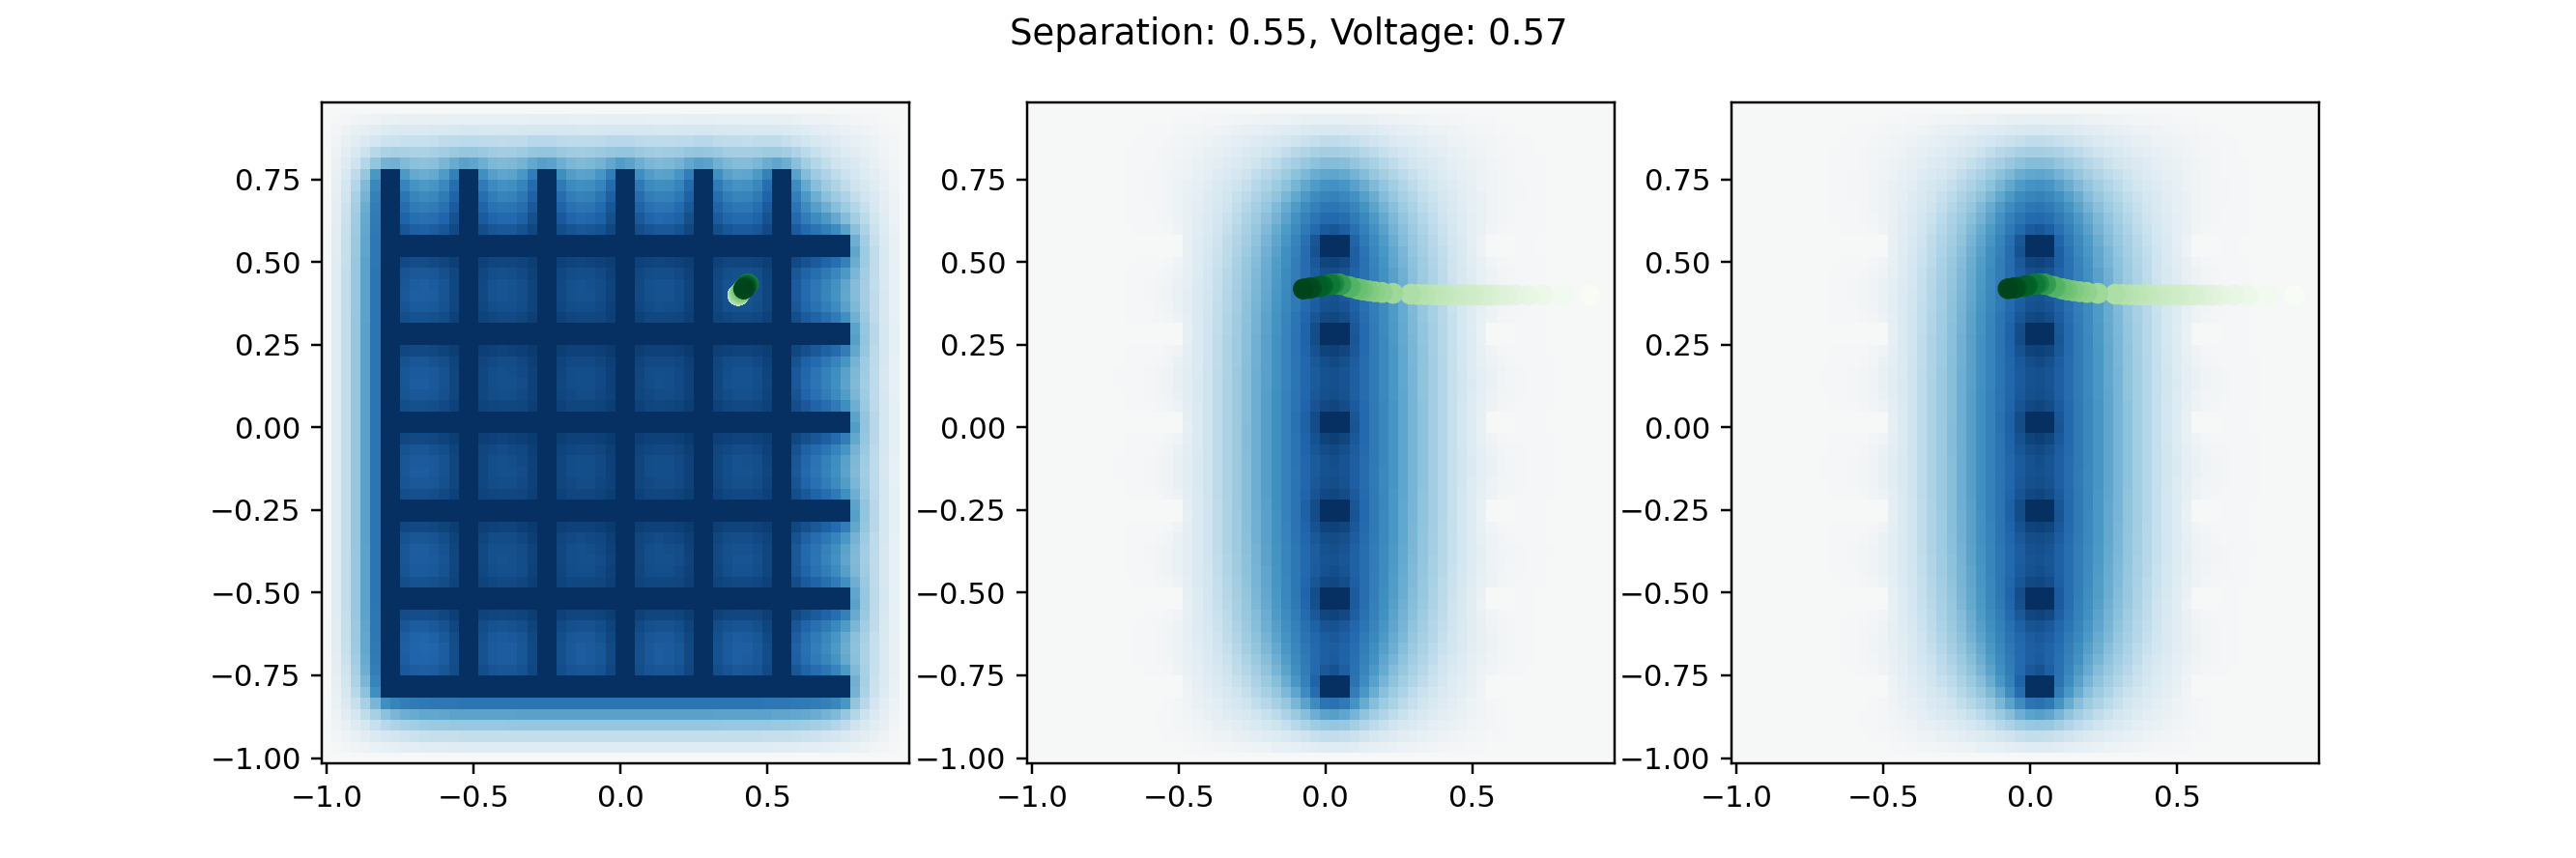

Computing Dependence
Computation Finished.


In [16]:
GRATE_SP = 0.25

separation_range = np.arange(0.1, 0.6, 0.05)
blocking_v = np.zeros(separation_range.shape)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.show()
video = VideoMaker(fig, axes)

def final_x_pos(sep_id, voltage):
    sim = generate_barrier_space(0, voltage, separation_range[sep_id], GRATE_SP, THICKNESS, SCALE)
    
    ctr = sim.global_unit_to_point((0, 0, 0))
    sq = round(separation_range[sep_id] * sim.scale)
    vs = sim.V[ctr[0],ctr[1]-sq:ctr[1]+sq,ctr[2]-sq:ctr[2]+sq]
    minv_pos = np.array(np.unravel_index(vs.argmin(), vs.shape))
    minv_pos += np.array([ctr[1]-sq, ctr[2]-sq])
    
    minv_loc = sim.point_to_global_unit(minv_pos)
    
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       (particle_opts["initial_loc"][0][0], minv_loc[0], minv_loc[1]),
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, TIME))
    
    video.new_frame()
    fig.suptitle("Separation: " + str(round(separation_range[sep_id], 2)) + ", Voltage: " + str(round(voltage, 2)))
    for i, ax in enumerate(axes):
        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=(0 if i==0 else minv_loc[i-1]))
        Visualizations.colormesh_2d(sim2d, color_norm=voltage, graph_ax=ax)
        Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)
    video.draw_frame()
    
    return particle.position[0][-1]

print("Computing Dependence")
qKE = particle_opts["charge"][0] * 0.5 * particle_opts["mass"][0] * (particle_opts["initial_v"][0][0]**2)
for i, separation in enumerate(separation_range):
    f = lambda v: final_x_pos(i, v)
    
    sol = root_scalar(f, method="bisect", bracket=[0.75*qKE, (1 + (0.5 / separation))*qKE], x0=qKE, xtol=0.01)
    blocking_v[i] = sol.root
    print("\r", round(separation, 2), ":", str(round(sol.root, 2)).rjust(4), end="")
print("\rComputation Finished.")
video.make_movie("grate_separation.mp4")

<IPython.core.display.Javascript object>


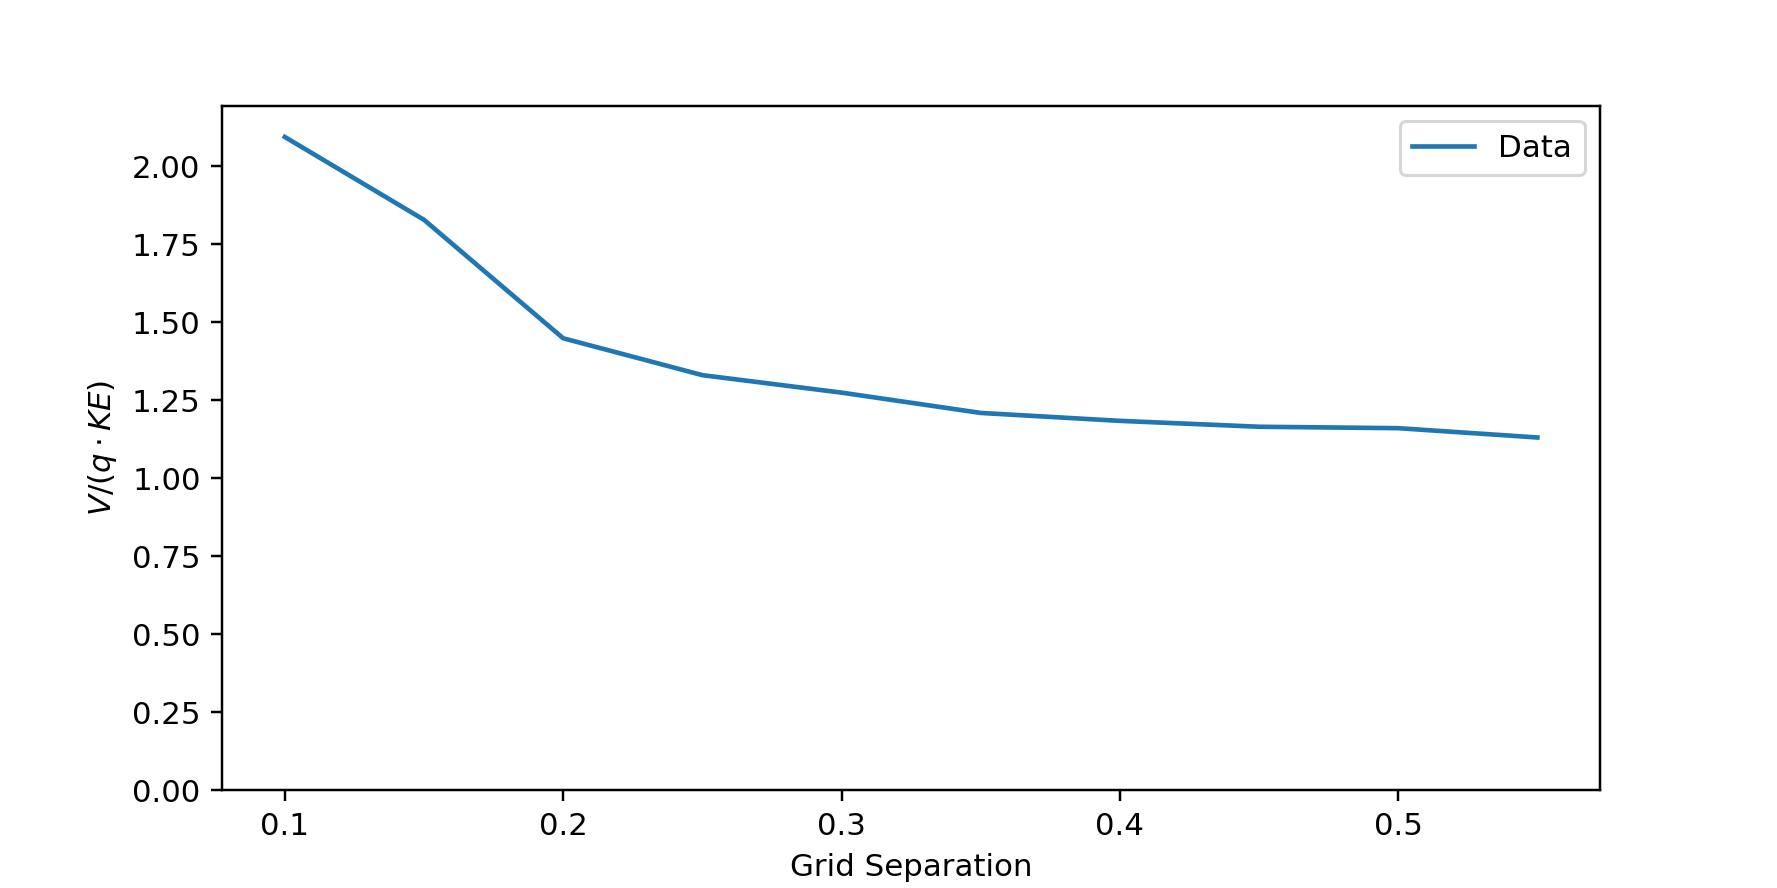

y = -1.85 * separation + 1.98


In [18]:
plt.figure(figsize=(8, 4))

rel_V = blocking_v / qKE

fit = np.polyfit(separation_range, rel_V, 1)
plt.plot(separation_range, rel_V, label="Data")
#plt.plot(separation_range, fit[0] * separation_range + fit[1], label="Linear Fit")
plt.legend()
plt.xlabel("Grid Separation")
plt.ylabel("$V / (q \cdot KE)$")
plt.ylim((0, max(rel_V)+0.1))
plt.show()

print("y = {:.2f} * separation + {:.2f}".format(*fit))